In [1]:
#   Using backtesting.py to perform backtesting on existing nasdaq data (scraped), yfinance data
from backtesting import Backtest, Strategy
import yfinance as yf

#   Using requests to grab sentiment data from EODHD
import requests

#   Using tensorflow and keras for machine learning
import tensorflow as tf
import keras

#   Some other important libraries
import pandas as pd
import numpy as np
from numpy import array, float32, hstack
from datetime import datetime

C:\Users\shell\anaconda3\Lib\site-packages\backtesting\_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [60]:
# Download and clean data from multiple sources for a given ticker
def get_data(ticker):
    hist = yf.Ticker(ticker).history(period="5y")['2021-01-04':]
    # Usual API Key: 65f87196205478.0796143
    sentiment = requests.get(f'https://eodhd.com/api/sentiments?s=' + ticker + '&from=2021-01-04&to=2024-03-18&api_token=65fa10c8b17a55.92906995&fmt=json').json()
    sentiments = pd.Series(sentiment[ticker + '.US'][i]['normalized'] for i in range(len(sentiment[ticker + '.US'])))
    dates = pd.Series(datetime.strptime(sentiment[ticker + '.US'][i]['date'], "%Y-%m-%d") for i in range(len(sentiment[ticker + '.US'])))
    sentiment_df = pd.concat([dates, sentiments], axis=1)
    sentiment_df.set_index(0, inplace=True)
    hist = hist.tz_localize(None)
    sentiment_df.join(hist)
    hist = hist.merge(sentiment_df, left_index=True, right_index=True)
    hist = hist.iloc[:, [0, 1, 2, 3, 4, 7]].rename(columns={1: 'Sentiment'})
    #hist['Target'] = [np.average(hist['Close'].iloc[i:i+5]) for i in range(len(hist)-5)] + [np.nan] * 5
    hist['Target'] = hist['Close'].shift(-1)
    hist = hist.iloc[:-5]
    upList, downList = list(), list()
    for i in range(len(hist)):
        if hist.iloc[i, 6] >= hist.iloc[i, 2] * 1.004:
            upList.append(1)
        else:
            upList.append(0)
        if hist.iloc[i, 6] <= hist.iloc[i, 2] * 0.996:
            downList.append(1)
        else:
            downList.append(0)
    hist = hist.drop('Target', axis=1)
    hist['Up'], hist['Down'] = upList, downList
    return hist

In [3]:
# Available Training Data: historical prices, historical sentiment data
def define_model():
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(5, 2)))
    model.add(keras.layers.LSTM(100, activation='relu', return_sequences=True))
    model.add(keras.layers.LSTM(100, activation='relu'))
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.Dense(50))
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    x, y = list(), list()
    for i in range(0, len(sequences) - n_steps, n_steps):
        x.append(sequences[i:i + n_steps, :-1])
        y.append(sequences[i+n_steps-1, -1])
    return array(x).astype(float32), array(y).astype(float32)

In [58]:
# Define the strategy for the model to be backtested on
class MLStrategy(Strategy):
    # The difference in gain and loss probabilities required to buy, to be optimized
    up_chance_delta = 0 # 0.0
    # The difference in gain and loss probabilities required to sell, to be optimized
    down_chance_delta = 20 # 0.2
    # The day-to-day change in a single probability required to buy/sell, to be optimized
    daily_delta = 20 # 0.2
    # The target take profit and stop loss
    price_delta = 20 # 2%

    def init(self):
        df = self.data.df
        self.n_train = int(0.85*len(df))
        train = df.iloc[:self.n_train]

        self.model_up, self.model_down = define_model(), define_model()

        in_seq1 = train.iloc[:, 3].to_numpy().reshape((len(train), 1))
        in_seq2 = train.iloc[:, 5].to_numpy().reshape((len(train), 1))
        out_seq_up = train.iloc[:, 6].to_numpy().reshape((len(train), 1))
        out_seq_down = train.iloc[:, 7].to_numpy().reshape((len(train), 1))

        x, y = split_sequences(hstack((in_seq1, in_seq2, out_seq_up)), 9)
        self.model_up.fit(x, y, verbose=False, epochs=200)

        x, y = split_sequences(hstack((in_seq1, in_seq2, out_seq_down)), 9)
        self.model_down.fit(x, y, verbose=False, epochs=200)

        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')

        # Get the model's first predictions
        input = array(df.iloc[self.n_train-9:self.n_train, [3, 5]]).reshape((1, 9, 2)).astype(float32)
        self.up_base = self.model_up.predict(input, verbose=False)
        self.down_base = self.model_down.predict(input, verbose=False)

    def next(self):
        df = self.data.df
        if len(self.data) < self.n_train:
            # Do nothing until testing data is reached
            return

        close, sentiment = self.data.Close, self.data.Sentiment
        current_time = self.data.index[-1]

        input = array(df.iloc[-9:, [3, 5]]).reshape((1, 9, 2)).astype(float32)
        up_chance = self.model_up.predict(input, verbose=False)
        down_chance = self.model_down.predict(input, verbose=False)

        if up_chance > self.up_base * self.daily_delta/100 and up_chance > down_chance + self.up_chance_delta/100:
            forecast = (up_chance - self.up_base)/self.up_base
        elif down_chance > self.down_base * self.daily_delta/100 and down_chance > up_chance + self.down_chance_delta/100:
            forecast = -(down_chance - self.down_base)/self.down_base
        else:
            forecast = 0

        self.forecasts[-1] = forecast
        upper, lower = close[-1] * (1 + np.r_[1, -1]*self.price_delta/1000)

        if forecast > 0:
            self.buy(size=.2, tp=upper, sl=lower)
        elif forecast < 0:
            self.sell(size=.2, tp=lower, sl=upper)

In [169]:
n = 9

model_up, model_down = define_model(), define_model()

data = get_data('AAPL')
train, test = data.iloc[:int(0.85*len(data))], data.iloc[int(0.85*len(data)):]
    
in_seq1 = train.iloc[:, 3].to_numpy().reshape((len(train), 1))
in_seq2 = train.iloc[:, 5].to_numpy().reshape((len(train), 1))
out_seq_up = train.iloc[:, 6].to_numpy().reshape((len(train), 1))
out_seq_down = train.iloc[:, 7].to_numpy().reshape((len(train), 1))
    
x, y = split_sequences(hstack((in_seq1, in_seq2, out_seq_up)), n)
model_up.fit(x, y, verbose=False, epochs=200)

x, y = split_sequences(hstack((in_seq1, in_seq2, out_seq_down)), n)
model_down.fit(x, y, verbose=False, epochs=200)

<Axes: >

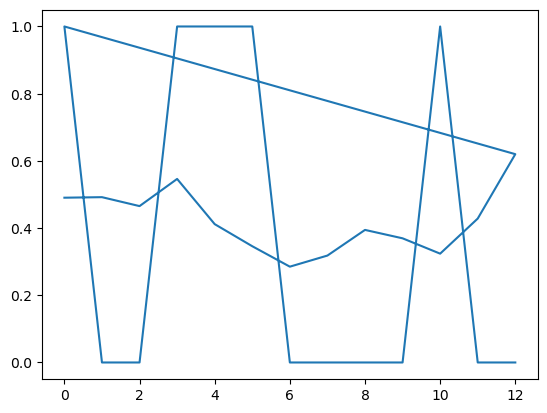

In [170]:
#input = array(test.iloc[-5:, [0, 1]]).reshape((1, 5, 2)).astype(float32)

in_seq1 = test.iloc[:, 3].to_numpy().reshape((len(test), 1))
in_seq2 = test.iloc[:, 5].to_numpy().reshape((len(test), 1))
out_seq_up = test.iloc[:, 6].to_numpy().reshape((len(test), 1))
out_seq_down = test.iloc[:, 7].to_numpy().reshape((len(test), 1))

x, y = split_sequences(hstack((in_seq1, in_seq2, out_seq_up)), n)

predictions = list()
for i in range(len(x)):
    prediction = model_up.predict(x[i].reshape((1, n, 2)), verbose=False)
    predictions.append(prediction[0][0])
pd.concat([pd.Series(predictions), pd.Series(y)]).plot()

<Axes: >

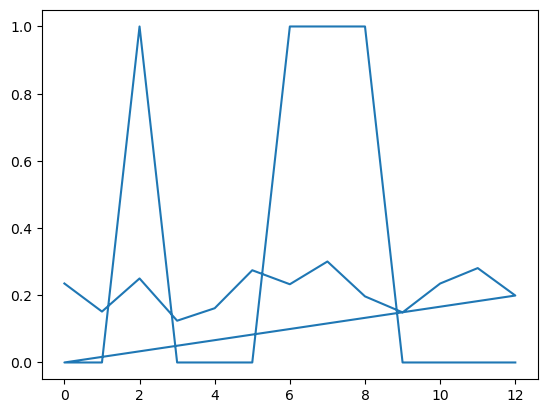

In [171]:
x, y = split_sequences(hstack((in_seq1, in_seq2, out_seq_down)), n)

predictions = list()
for i in range(len(x)):
    prediction = model_down.predict(x[i].reshape((1, n, 2)), verbose=False)
    predictions.append(prediction[0][0])
pd.concat([pd.Series(predictions), pd.Series(y)]).plot()

In [67]:
data = get_data('PEP')
bt = Backtest(data, MLStrategy, commission=.0002, margin=.05)
bt.run()
bt.plot(plot_volume=False, plot_pl=True)

C:\Users\shell\AppData\Local\Temp\ipykernel_14056\2720714465.py:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.forecasts[-1] = forecast
C:\Users\shell\anaconda3\Lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\shell\anaconda3\Lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\shell\anaconda3\Lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
C:\Users\s

GridPlot(id='p8697', ...)

In [13]:
ticker_list = ['AAPL', 'MSFT', 'COST', 'PG', 'JNJ', 'PEP', 'WMT', 'KO', 'MCD', 'GE']
total_return = 0
for ticker in ticker_list:
    print(ticker + ':')
    data = get_data(ticker)
    bt = Backtest(data, MLStrategy, commission=.0002, margin=.05)
    total_return += bt.run()['Return [%]']
    bt.plot(plot_volume=False, plot_pl=True)
print(total_return/10)

AAPL:


C:\Users\shell\anaconda3\Lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\shell\anaconda3\Lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\shell\anaconda3\Lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
C:\Users\shell\anaconda3\Lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


MSFT:


C:\Users\shell\anaconda3\Lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\shell\anaconda3\Lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\shell\anaconda3\Lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
C:\Users\shell\anaconda3\Lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


COST:


C:\Users\shell\anaconda3\Lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\shell\anaconda3\Lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\shell\anaconda3\Lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
C:\Users\shell\anaconda3\Lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


PG:


C:\Users\shell\anaconda3\Lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\shell\anaconda3\Lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\shell\anaconda3\Lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
C:\Users\shell\anaconda3\Lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


JNJ:


C:\Users\shell\anaconda3\Lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\shell\anaconda3\Lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\shell\anaconda3\Lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
C:\Users\shell\anaconda3\Lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


PEP:


C:\Users\shell\anaconda3\Lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\shell\anaconda3\Lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\shell\anaconda3\Lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
C:\Users\shell\anaconda3\Lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


WMT:


C:\Users\shell\anaconda3\Lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\shell\anaconda3\Lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\shell\anaconda3\Lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
C:\Users\shell\anaconda3\Lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


KO:


C:\Users\shell\anaconda3\Lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\shell\anaconda3\Lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\shell\anaconda3\Lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
C:\Users\shell\anaconda3\Lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


MCD:


C:\Users\shell\anaconda3\Lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\shell\anaconda3\Lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\shell\anaconda3\Lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
C:\Users\shell\anaconda3\Lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


GE:


C:\Users\shell\anaconda3\Lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\shell\anaconda3\Lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\shell\anaconda3\Lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
C:\Users\shell\anaconda3\Lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


115.41063054049371


In [42]:
#stats = bt.optimize(up_chance_delta=range(0, 20, 10),
#                    down_chance_delta=range(0, 20, 10),
#                    daily_delta=range(10, 30, 10),
#                    maximize='Equity Final [$]')
stats = bt.optimize(price_delta=range(4, 24, 4),
                    maximize='Equity Final [$]')
print(stats._strategy)

  0%|          | 0/4 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [44]:
# AAPL (4-day):
# 0.0
# 0.2
# 0.2

# MSFT (4-day):
# 0.1
# 0.0
# 0.2

# NVDA (1-day):
# 0.0
# 0.1
# 0.1

# COST (4-day):
# 0.0
# 0.0
# 0.2

# AAPL settings might have some of the best returns overall for:
# PG, JNJ, MRK, PEP, WMT, KO

# Returns can be volatile based on the model. 
# The best solution to this might be to develop a model based on EV instead of probability (or confidence)
# Focus on meaningful data, such as exchange/sector specific data and trade those kinds of stocks

# Watch for: earnings, pharmaceuticals, and lawsuits